# GloFAS - extract time series
***

**Author:** Chus Casado Rodr√≠guez<br>
**Date:** 18-09-2023<br>

**Introduction:**<br>


In [4]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import yaml

import warnings
warnings.filterwarnings('ignore')

In [20]:
import geopandas as gpd

### Configuration

In [5]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
path_out = Path(cfg['path_out'])
if path_out.exists() is False:
    path_out.mkdir()
var = cfg['var']

In [19]:
path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

### ResOpsUS

In [22]:
# import shapefile
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')
resops = gpd.read_file(path_ResOps / 'GIS' / 'reservoirs.shp')
resops.set_index('DAM_ID', drop=True, inplace=True)

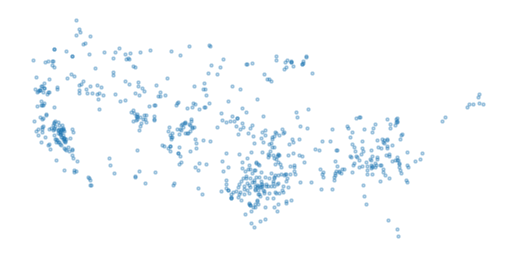

In [24]:
# plot reservoir locations
fig, ax = plt.subplots()
ax.scatter(resops.geometry.x, resops.geometry.y, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### GloFAS
#### Shapefile

In [53]:
# load GloFAS reservoirs
path_GloFAS = Path('../data/reservoirs/GloFAS')
glofas_shp = gpd.read_file(path_GloFAS / 'GloFAS_reservoirs.shp')
glofas_shp.GRAND_ID = glofas_shp.GRAND_ID.astype(pd.Int64Dtype())
glofas_shp.GLWD_ID = glofas_shp.GLWD_ID.astype(pd.Int64Dtype())
glofas_shp.set_index('GRAND_ID', inplace=True)

# keep only reservoirs in ResOpsUS
mask = glofas_shp.index.intersection(resops.index)
glofas_shp = glofas_shp.loc[mask]

# remove duplicates
glofas_shp = glofas_shp[~glofas_shp.index.duplicated(keep='first')]

glofas_shp.sort_index(axis=0, inplace=True)

#### Raster

In [58]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
# ids = np.unique(glofas_raster.where(~glofas_raster.isnull(), drop=True))
# ids = ids[~np.isnan(ids) & (ids != -9999)]
# ids = ids.astype(int)
ids = glofas_shp.ResID.sort_values().values

In [59]:
# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]

  0%|          | 0/121 [00:00<?, ?it/s]

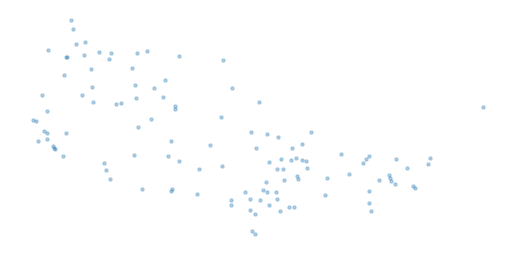

In [61]:
# plot reservoir locations
fig, ax = plt.subplots()
ax.scatter(lon.data, lat.data, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### Time series of reservoir storage

In [67]:
for file in tqdm(glob.glob(f'{path_ts}/{var}_????.nc')):
    
    # load NetCDF file
    da = xr.open_dataset(file, chunks={'time': 1})[var]
    
    # extract time series for each ID
    arr = np.zeros((len(da.time), len(ids))) * np.nan
    for n, id in tqdm(zip(range(len(ids)), ids)):
        # location in the longitude and latitude dimensions
        i = np.where(np.isclose(da.lon.data, lon.sel(ResID=id).data, atol=1e-3))[0][0]
        j = np.where(np.isclose(da.lat.data, lat.sel(ResID=id).data, atol=1e-3))[0][0]
        # extract
        arr[:,n] = da.data[:,j,i]#.compute()
    
    # convert to xr.DataArray    
    da_extract = xr.DataArray(arr, dims=['time', 'ResID'], coords={'time': da.time, 'ResID': lon.ResID})
    da_extract.attrs = da.attrs

    # export extraction
    da_extract.to_netcdf(str(file).replace('.nc', f'_extract{len(ids)}.nc'))

  0%|          | 0/39 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 